## Kết nối Drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Importing Libraries:

In [2]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import re
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, PorterStemmer
import math
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc, mean_squared_error
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
import gensim
import string
import tensorflow as tf
import keras

##Loading data

In [3]:
X_train = pd.read_pickle('/content/gdrive/MyDrive/Python/X_train.pkl')
X_cv = pd.read_pickle('/content/gdrive/MyDrive/Python/X_cv.pkl')
X_test = pd.read_pickle('/content/gdrive/MyDrive/Python/X_test.pkl')
y_train = pd.read_pickle('/content/gdrive/MyDrive/Python/y_train.pkl')
y_cv = pd.read_pickle('/content/gdrive/MyDrive/Python/y_cv.pkl')

In [ ]:
X_train.head()

,preprocessed_text
id,
5824311,interest histori american conservat particular...
544525,issu abort negoti refus grappl complex moral e...
802251,sick fellow alreadi hasn t even start presid c...
5238864,hope paul romanuk sen seem want angl everyth w...
1084892,guess s high must danger use sigh


In [ ]:
X_cv.head()

,preprocessed_text
id,
4999426,definit suppos don t use good servic suppli go...
6107692,entir west coast legal pot recreat use reap be...
451471,wrong promot kind behavior don t support greed...
4970247,mayb manpreet address problem knew decemb one ...
6314618,sort provinci lib paid eras evid now seek ever...


In [ ]:
y_train

,target
id,
5824311,0.0
544525,0.0
802251,0.0
5238864,0.0
1084892,0.0
...,...
366102,0.0
5737285,0.0
696055,0.0


In [ ]:
y_cv

,target
id,
4999426,0.000000
6107692,0.000000
451471,0.000000
4970247,0.000000
6314618,0.000000
...,...
648655,0.500000
835957,0.000000
5358077,0.000000


#Model

##1. Bag of Words (BoW):

In [ ]:
%%time
cnt_vec = CountVectorizer(ngram_range=(1,2), max_features=30000)
bow_train = cnt_vec.fit_transform(X_train['preprocessed_text'])
bow_cv = cnt_vec.transform(X_cv['preprocessed_text'])
bow_test = cnt_vec.transform(X_test['preprocessed_text'])

print(bow_train.shape)
print(bow_cv.shape)
print(bow_test.shape)

(1353655, 30000)
(451219, 30000)
(97320, 30000)
CPU times: user 2min 21s, sys: 2.81 s, total: 2min 24s
Wall time: 2min 27s


###1.1 SGDRegressor:

1.1.1 Hyperparameter Tuning:

In [ ]:

# Performing hyperparameter tuning:
alpha = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
penalty = ['l1', 'l2']
xticks = []
tr_errors = []
cv_errors = []
best_model = None
best_error = 100
for a in alpha:
    for p in penalty:
        xticks.append(str(a) + ' ' + p)
        print(str(a) + ' ' + p + " :")
        
        model = SGDRegressor(alpha=a, penalty=p) 
        model.fit(bow_train, y_train.values.ravel()) # Train
        
        preds = model.predict(bow_train) # Get predictions
        err = mean_squared_error(y_train['target'], preds) # Calculate error on trainset
        tr_errors.append(err)
        print("Mean Squared Error on train set: ", err)
        
        preds = model.predict(bow_cv) # Get predictions on CV set
        err = mean_squared_error(y_cv['target'], preds) # Calculate error on cv set
        cv_errors.append(err)
        print("Mean Squared Error on cv set: ", err)
        
        if err < best_error: # Get best model trained
            best_error = err
            best_model = model
        
        print("*"*50)

1e-05 l1 :
Mean Squared Error on train set:  0.8115639503171432
Mean Squared Error on cv set:  0.3595356036576513
**************************************************
1e-05 l2 :
Mean Squared Error on train set:  0.029322318950490384
Mean Squared Error on cv set:  0.022704739204233108
**************************************************
0.0001 l1 :
Mean Squared Error on train set:  0.024544877355962124
Mean Squared Error on cv set:  0.024329467193874972
**************************************************
0.0001 l2 :
Mean Squared Error on train set:  0.4071599841790608
Mean Squared Error on cv set:  0.029897985405523388
**************************************************
0.001 l1 :
Mean Squared Error on train set:  0.031505222122441466
Mean Squared Error on cv set:  0.031357431451659264
**************************************************
0.001 l2 :
Mean Squared Error on train set:  0.04563350533861521
Mean Squared Error on cv set:  0.02380689946950138
*******************************************

In [ ]:
y_train_lg = np.array(y_train.values.ravel() > 0.1, dtype=np.float)
y_test_lg = np.array(y_cv.values.ravel() > 0.1, dtype=np.float)

model = MultinomialNB() 
model.fit(bow_train, y_train_lg)

predictions = model.predict_proba(bow_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [ ]:
predictions[1:5]

array([[0.00308478, 0.99691522],
       [0.23448919, 0.76551081],
       [0.87258268, 0.12741732],
       [0.71058087, 0.28941913]])

In [ ]:
from sklearn.naive_bayes import MultinomialNB

model = MultinomialNB() 
model.fit(bow_train, y_train.values.ravel())

ValueError: ignored

In [ ]:
y_train.values.ravel()

array([0., 0., 0., ..., 0., 0., 0.])

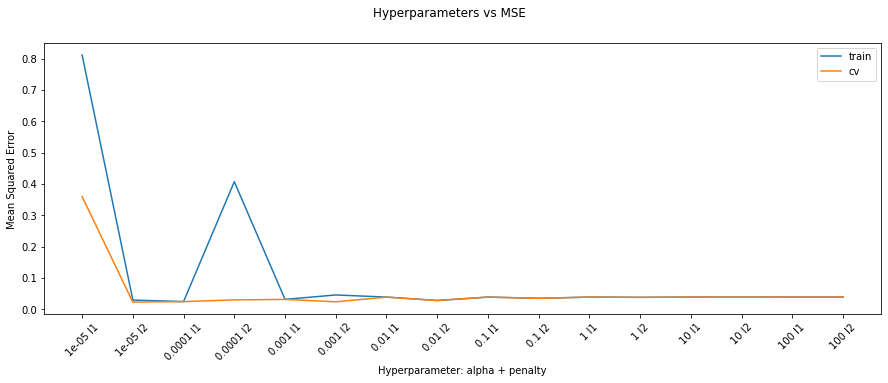

In [ ]:
plt.figure(figsize=(15,5))
plt.suptitle("Hyperparameters vs MSE")
plt.plot(range(len(alpha) * len(penalty)), tr_errors)
plt.plot(range(len(alpha) * len(penalty)), cv_errors)
plt.legend(['train', 'cv'])
plt.xticks(range(len(alpha) * len(penalty)), xticks, rotation=45)
plt.xlabel('Hyperparameter: alpha + penalty')
plt.ylabel('Mean Squared Error')
plt.show()

In [ ]:
# Getting the best model parameters:
best_model.get_params()

{'alpha': 0.001,
 'average': False,
 'early_stopping': False,
 'epsilon': 0.1,
 'eta0': 0.01,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'learning_rate': 'invscaling',
 'loss': 'squared_error',
 'max_iter': 1000,
 'n_iter_no_change': 5,
 'penalty': 'l2',
 'power_t': 0.25,
 'random_state': None,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

1.1.2 Feature Importance:

In [ ]:
# Printing the 20 most important features/words which contribute to a comment being toxic.
feat_names = cnt_vec.get_feature_names()
weights = best_model.coef_
df = pd.DataFrame(data=weights, columns=['weights'], index=feat_names)
df.sort_values("weights", ascending=False).iloc[0:20,:]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,weights
idiot,0.379577
stupid,0.330781
great great,0.303762
pathet,0.242098
moron,0.237713
crap,0.223176
dumb,0.221271
hypocrit,0.219537
fool,0.195460
clown,0.190643


In [ ]:
# 20 most important features/words which contribute to comment being non-toxic.
df.sort_values("weights", ascending=True).iloc[0:20,:]

,weights
great great,-0.239051
stupid stupid,-0.087418
knee jerk,-0.073949
fool peopl,-0.050890
black white,-0.050593
don fool,-0.046039
ignor fact,-0.037288
winner loser,-0.034148
dumb dumb,-0.032873
white hous,-0.030487


###1.2 Decision Trees:

1.2.1 Hyperparameter Tuning:

In [ ]:
%%time
# Performing hyperparameter tuning:
max_depth = [3, 5, 7]
min_samples = [10, 100, 1000]
xticks = []
tr_errors = []
cv_errors = []
best_model = None
best_error = 100
for d in max_depth:
    for samp in min_samples:
        xticks.append("Depth- " + str(d) + ' Min Samples leaf-' + str(samp))
        print("Depth- " + str(d) + ' Min Samples leaf-' + str(samp) + " :")
        
        model = DecisionTreeRegressor(max_depth=d, min_samples_leaf=samp)
        model.fit(bow_train, y_train) # Train
        
        preds = model.predict(bow_train) # Get predictions
        err = mean_squared_error(y_train['target'], preds) # Calculate error on trainset
        tr_errors.append(err)
        print("Mean Squared Error on train set: ", err)
        
        preds = model.predict(bow_cv) # Get predictions on CV set
        err = mean_squared_error(y_cv['target'], preds) # Calculate error on cv set
        cv_errors.append(err)
        print("Mean Squared Error on cv set: ", err)
        
        if err < best_error: # Get best model trained
            best_error = err
            best_model = model
        
        print("*"*50)

Depth- 3 Min Samples leaf-10 :
Mean Squared Error on train set:  0.03312776246413169
Mean Squared Error on cv set:  0.03303789084153376
**************************************************
Depth- 3 Min Samples leaf-100 :
Mean Squared Error on train set:  0.03312776246413169
Mean Squared Error on cv set:  0.033037890841533746
**************************************************
Depth- 3 Min Samples leaf-1000 :
Mean Squared Error on train set:  0.03313102332832436
Mean Squared Error on cv set:  0.03304078194504544
**************************************************
Depth- 5 Min Samples leaf-10 :
Mean Squared Error on train set:  0.032043453912919725
Mean Squared Error on cv set:  0.03195533283517747
**************************************************
Depth- 5 Min Samples leaf-100 :
Mean Squared Error on train set:  0.032046780695585496
Mean Squared Error on cv set:  0.0319513607285594
**************************************************
Depth- 5 Min Samples leaf-1000 :
Mean Squared Error on trai

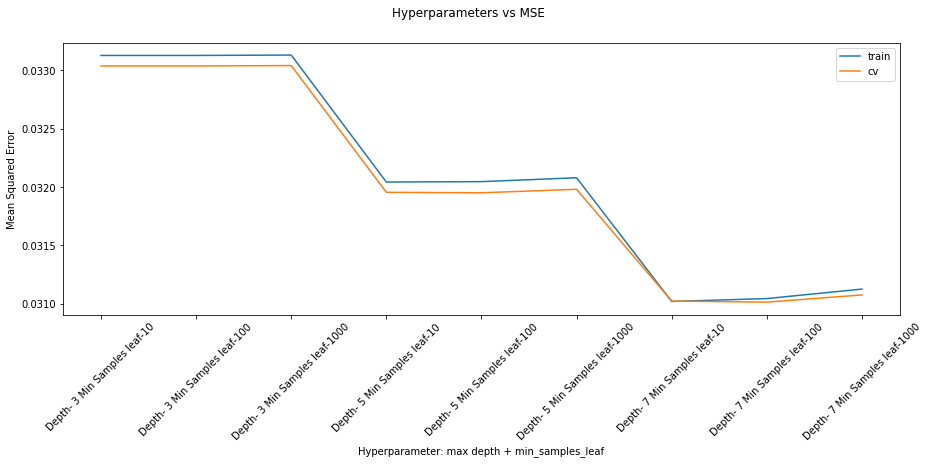

In [ ]:
plt.figure(figsize=(15,5))
plt.suptitle("Hyperparameters vs MSE")
plt.plot(range(len(max_depth) * len(min_samples)), tr_errors)
plt.plot(range(len(max_depth) * len(min_samples)), cv_errors)
plt.legend(['train', 'cv'])
plt.xticks(range(len(max_depth) * len(min_samples)), xticks, rotation=45)
plt.xlabel('Hyperparameter: max depth + min_samples_leaf')
plt.ylabel('Mean Squared Error')
plt.show()

In [ ]:
# Best models parameters:
best_model.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 7,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 100,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

1.2.2 Feature Importance:

In [ ]:
weights = best_model.feature_importances_
df = pd.DataFrame(data=weights, columns=['weights'], index=feat_names)
df.sort_values("weights", ascending=False).iloc[0:20,:]

,weights
stupid,0.396553
idiot,0.263428
pathet,0.068965
fool,0.067580
moron,0.062551
white,0.059646
dumb,0.055083
racist,0.005945
will,0.004257
peopl,0.002529


##2. Term Frequency - Inverse Document Frequency (TFIDF) :

In [ ]:
tfidf_vec = TfidfVectorizer(ngram_range=(1,2), max_features=30000)
tfidf_train = tfidf_vec.fit_transform(X_train['preprocessed_text'])
tfidf_cv = tfidf_vec.transform(X_cv['preprocessed_text'])
tfidf_test = tfidf_vec.transform(X_test['preprocessed_text'])

print(tfidf_train.shape)
print(tfidf_cv.shape)
print(tfidf_test.shape)

(1353655, 30000)
(451219, 30000)
(97320, 30000)


###2.1 SGDRegressor:


2.1.1 Hyperparameter Tuning:

In [ ]:
# Performing hyperparameter tuning:
alpha = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
penalty = ['l1', 'l2']
xticks = []
tr_errors = []
cv_errors = []
best_model = None
best_error = 100
for a in alpha:
    for p in penalty:
        xticks.append(str(a) + ' ' + p)
        print(str(a) + ' ' + p + " :")
        
        model = SGDRegressor(alpha=a, penalty=p) 
        model.fit(tfidf_train, y_train) # Train
        
        preds = model.predict(tfidf_train) # Get predictions
        err = mean_squared_error(y_train['target'], preds) # Calculate error on trainset
        tr_errors.append(err)
        print("Mean Squared Error on train set: ", err)
        
        preds = model.predict(tfidf_cv) # Get predictions on CV set
        err = mean_squared_error(y_cv['target'], preds) # Calculate error on cv set
        cv_errors.append(err)
        print("Mean Squared Error on cv set: ", err)
        
        if err < best_error: # Get best model trained
            best_error = err
            best_model = model
        
        print("*"*50)

1e-05 l1 :


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Squared Error on train set:  0.025307125588329118
Mean Squared Error on cv set:  0.02522284328820076
**************************************************
1e-05 l2 :


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Squared Error on train set:  0.02393040346588932
Mean Squared Error on cv set:  0.023900470685040788
**************************************************
0.0001 l1 :


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Squared Error on train set:  0.029756014370629955
Mean Squared Error on cv set:  0.029650895129790397
**************************************************
0.0001 l2 :


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Squared Error on train set:  0.02505119894499655
Mean Squared Error on cv set:  0.025006738917053732
**************************************************
0.001 l1 :


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Squared Error on train set:  0.03832861744879092
Mean Squared Error on cv set:  0.03818153123032058
**************************************************
0.001 l2 :


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Squared Error on train set:  0.030113014480652067
Mean Squared Error on cv set:  0.030016401697305992
**************************************************
0.01 l1 :


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Squared Error on train set:  0.038879004090579546
Mean Squared Error on cv set:  0.03871838551783037
**************************************************
0.01 l2 :


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Squared Error on train set:  0.03719211852730615
Mean Squared Error on cv set:  0.037040331633128865
**************************************************
0.1 l1 :


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Squared Error on train set:  0.03887900225129933
Mean Squared Error on cv set:  0.038718398287041454
**************************************************
0.1 l2 :


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Squared Error on train set:  0.03869235496031562
Mean Squared Error on cv set:  0.038532705405500835
**************************************************
1 l1 :


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Squared Error on train set:  0.03887898457082094
Mean Squared Error on cv set:  0.038718376538000955
**************************************************
1 l2 :


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Squared Error on train set:  0.0388606029745042
Mean Squared Error on cv set:  0.0387000427293918
**************************************************
10 l1 :


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Squared Error on train set:  0.03887898328825728
Mean Squared Error on cv set:  0.038718374719268145
**************************************************
10 l2 :


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Squared Error on train set:  0.038876818777108225
Mean Squared Error on cv set:  0.038716212733626965
**************************************************
100 l1 :


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Squared Error on train set:  0.03887898584886438
Mean Squared Error on cv set:  0.03871837118701
**************************************************
100 l2 :


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Squared Error on train set:  0.03887886092342472
Mean Squared Error on cv set:  0.03871824643688362
**************************************************


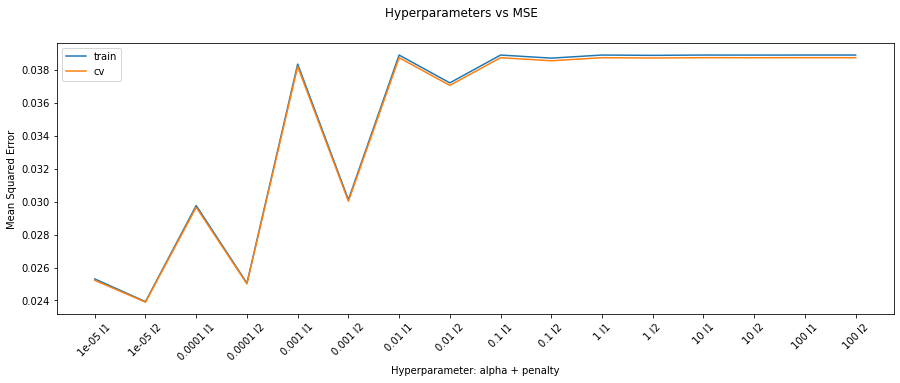

In [ ]:
plt.figure(figsize=(15,5))
plt.suptitle("Hyperparameters vs MSE")
plt.plot(range(len(alpha) * len(penalty)), tr_errors)
plt.plot(range(len(alpha) * len(penalty)), cv_errors)
plt.legend(['train', 'cv'])
plt.xticks(range(len(alpha) * len(penalty)), xticks, rotation=45)
plt.xlabel('Hyperparameter: alpha + penalty')
plt.ylabel('Mean Squared Error')
plt.show()

In [ ]:
best_model.get_params()


{'alpha': 1e-05,
 'average': False,
 'early_stopping': False,
 'epsilon': 0.1,
 'eta0': 0.01,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'learning_rate': 'invscaling',
 'loss': 'squared_error',
 'max_iter': 1000,
 'n_iter_no_change': 5,
 'penalty': 'l2',
 'power_t': 0.25,
 'random_state': None,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

2.1.2 Feature Importance:


In [ ]:
# Printing the 20 most important features/words which contribute to a comment being toxic.
feat_names = tfidf_vec.get_feature_names()
weights = best_model.coef_
df = pd.DataFrame(data=weights, columns=['weights'], index=feat_names)
df.sort_values("weights", ascending=False).iloc[0:20,:]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,weights
stupid,1.573949
idiot,1.274939
fool,0.665652
ignor,0.615116
dumb,0.602151
pathet,0.585808
moron,0.569647
ridicul,0.564846
loser,0.555972
liar,0.519119


In [ ]:
# 20 most important features/words which contribute to comment being non-toxic.
df.sort_values("weights", ascending=True).iloc[0:20,:]

,weights
thank,-0.094060
interest,-0.087666
https,-0.081805
agre,-0.078295
great,-0.076427
stori,-0.075795
differ,-0.071862
new,-0.071846
may,-0.069856
good,-0.069480


###1.2 Decision Trees:

1.2.1 Hyperparameter Tuning:


In [ ]:
max_depth = [3, 5, 7]
min_samples = [10, 100, 1000]
xticks = []
tr_errors = []
cv_errors = []
best_model = None
best_error = 100
for d in max_depth:
    for samp in min_samples:
        xticks.append("Depth- " + str(d) + ' Min Samples leaf-' + str(samp))
        print("Depth- " + str(d) + ' Min Samples leaf-' + str(samp) + " :")
        
        model = DecisionTreeRegressor(max_depth=d, min_samples_leaf=samp)
        model.fit(tfidf_train, y_train) # Train
        
        preds = model.predict(tfidf_train) # Get predictions
        err = mean_squared_error(y_train['target'], preds) # Calculate error on trainset
        tr_errors.append(err)
        print("Mean Squared Error on train set: ", err)
        
        preds = model.predict(tfidf_cv) # Get predictions on CV set
        err = mean_squared_error(y_cv['target'], preds) # Calculate error on cv set
        cv_errors.append(err)
        print("Mean Squared Error on cv set: ", err)
        
        if err < best_error: # Get best model trained
            best_error = err
            best_model = model
        
        print("*"*50)

Depth- 3 Min Samples leaf-10 :
Mean Squared Error on train set:  0.03291995085558299
Mean Squared Error on cv set:  0.03284303835841888
**************************************************
Depth- 3 Min Samples leaf-100 :
Mean Squared Error on train set:  0.03291995085558298
Mean Squared Error on cv set:  0.032843038358418876
**************************************************
Depth- 3 Min Samples leaf-1000 :
Mean Squared Error on train set:  0.03291995085558298
Mean Squared Error on cv set:  0.03284303835841887
**************************************************
Depth- 5 Min Samples leaf-10 :
Mean Squared Error on train set:  0.03178278881196575
Mean Squared Error on cv set:  0.03169198311459545
**************************************************
Depth- 5 Min Samples leaf-100 :
Mean Squared Error on train set:  0.03178398892400098
Mean Squared Error on cv set:  0.03169343833782801
**************************************************
Depth- 5 Min Samples leaf-1000 :
Mean Squared Error on train

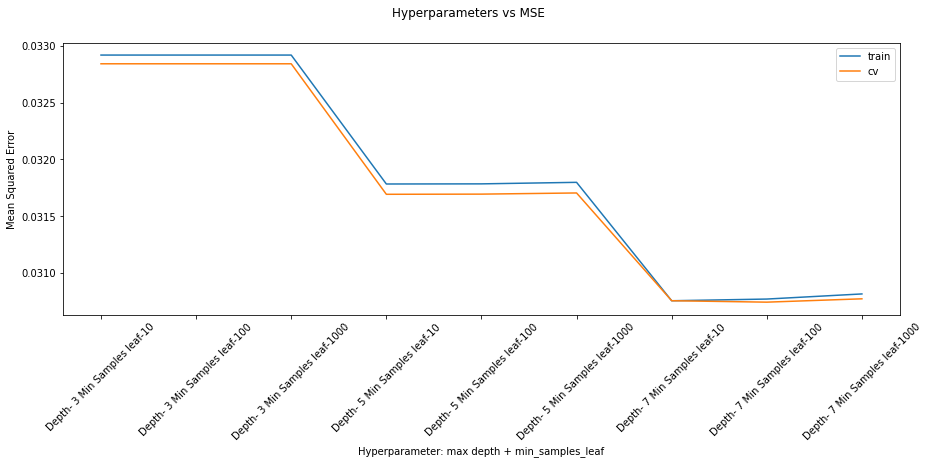

In [ ]:
plt.figure(figsize=(15,5))
plt.suptitle("Hyperparameters vs MSE")
plt.plot(range(len(max_depth) * len(min_samples)), tr_errors)
plt.plot(range(len(max_depth) * len(min_samples)), cv_errors)
plt.legend(['train', 'cv'])
plt.xticks(range(len(max_depth) * len(min_samples)), xticks, rotation=45)
plt.xlabel('Hyperparameter: max depth + min_samples_leaf')
plt.ylabel('Mean Squared Error')
plt.show()

In [ ]:
best_model.get_params()


{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 7,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 100,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

1.2.2 Feature Importance:


In [ ]:
weights = best_model.feature_importances_
df = pd.DataFrame(data=weights, columns=['weights'], index=feat_names)
df.sort_values("weights", ascending=False).iloc[0:20,:]

,weights
stupid,0.405818
idiot,0.267577
fool,0.071791
pathet,0.070770
moron,0.063321
white,0.058562
dumb,0.054024
racist,0.005407
don fool,0.000703
trump,0.000567


##3. LSTM:

In [4]:
class LSTMFeaturization:
    
    def __init__(self):
        self.word_mapping = None
        self.total_words = None
        
    
    #input : tập những comments, output: tập vocab dạng dict(key = word, value = count of word)
    def build_vocabulary(self, sentences):
        
        vocab = set()
        for x in sentences:
            for word in x.split():
                vocab.add(word)
        
        vocab_dict = dict.fromkeys(vocab, 0)
        
        for x in sentences:
            for word in x.split():
                vocab_dict[word]+=1
                
        return vocab_dict
    
    
    
    # Tạo vocab - dict(word, word number) // gần giống với onehotvector
    def get_mapping(self, vocab_dict):
                
        # Get the number of each word into the corpus.
        k = []
        v = []
        for keys,val in vocab_dict.items():
            k.append(keys)
            v.append(val)
            
        kv = np.vstack((k,v)).T
        df = pd.DataFrame(columns=["Word","Count"], data=kv)
        df['Count'] = df['Count'].astype('int')
        
        # Sort the dataframe to get the largest count at first place
        df.sort_values(by=['Count'], ascending=False, inplace=True)
        
        # Give numbering to the most frequent word as 1 then next as 2 and so on.
        df.reset_index(inplace=True)
        df['mapping'] = df.index + 1
        
        df.drop(columns=['index'], inplace=True)
        df.drop(columns=['Count'], inplace=True)
        
        # Convert to dictionary for easier processing.
        dictionary = dict(zip(df['Word'], df['mapping']))
        
        return dictionary
    
    
    # Accepts a list of sentences and generates vocabulary and word mappings.
    def fit(self, sentences):
        v = self.build_vocabulary(sentences)
        self.word_mapping = self.get_mapping(v)
        self.total_words = len(self.word_mapping)
        
    # Converts the sentences to number mappings.
    def transform(self, sentences, pad_length = 350):
        
        whole = list() # Stores mapping for all sentences
        for x in sentences: # for each sentence in list of sentences.
            
            part = list()
            for word in x.split(): # for each word
                if word in self.word_mapping:
                    part.append(self.word_mapping[word]) # Append mapped number.
            whole.append(part) # Append sentence.
        
        # Append additional values to make lengths equal.
        whole = keras.preprocessing.sequence.pad_sequences(np.array(whole), maxlen=pad_length)
        
        return whole

In [5]:
lstmfeat = LSTMFeaturization()
lstmfeat.fit(X_train['preprocessed_text'])

lstm_train = lstmfeat.transform(X_train['preprocessed_text'])
lstm_test = lstmfeat.transform(X_test['preprocessed_text'])
lstm_cv = lstmfeat.transform(X_cv['preprocessed_text'])

print(lstm_train.shape)
print(lstm_cv.shape)
print(lstm_test.shape)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:75: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


(1353655, 350)
(451219, 350)
(97320, 350)


In [6]:
import keras
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import CuDNNLSTM
from keras.layers import Dropout
from keras.layers.embeddings import Embedding
import warnings
from keras import backend as K

In [7]:
# create the model
embedding_vecor_length = 100
total_words = lstmfeat.total_words
model = Sequential()
model.add(Embedding(total_words ,embedding_vecor_length, input_length=350))
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mse'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 350, 100)          20164000  
                                                                 
 lstm (LSTM)                 (None, 350, 128)          117248    
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 20,412,961
Trainable params: 20,412,961
Non-trainable params: 0
_________________________________________________________________
None


In [8]:
filepath="weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [9]:
%%time
history = model.fit(lstm_train, y_train, epochs=5,
                    batch_size=2048, validation_data=(lstm_cv, y_cv), verbose = 1, callbacks=callbacks_list)

Epoch 1/5
661/661 [==============================] - ETA: 0s - loss: 0.0213 - mse: 0.0213
Epoch 1: val_loss improved from -inf to 0.01618, saving model to weights-improvement-01-0.02.hdf5
661/661 [==============================] - 357s 526ms/step - loss: 0.0213 - mse: 0.0213 - val_loss: 0.0162 - val_mse: 0.0162
Epoch 2/5
661/661 [==============================] - ETA: 0s - loss: 0.0157 - mse: 0.0157
Epoch 2: val_loss did not improve from 0.01618
661/661 [==============================] - 351s 532ms/step - loss: 0.0157 - mse: 0.0157 - val_loss: 0.0157 - val_mse: 0.0157
Epoch 3/5
661/661 [==============================] - ETA: 0s - loss: 0.0152 - mse: 0.0152
Epoch 3: val_loss did not improve from 0.01618
661/661 [==============================] - 351s 531ms/step - loss: 0.0152 - mse: 0.0152 - val_loss: 0.0155 - val_mse: 0.0155
Epoch 4/5
661/661 [==============================] - ETA: 0s - loss: 0.0147 - mse: 0.0147
Epoch 4: val_loss did not improve from 0.01618
661/661 [=================

Text(0.5, 1.0, 'Loss Curves')

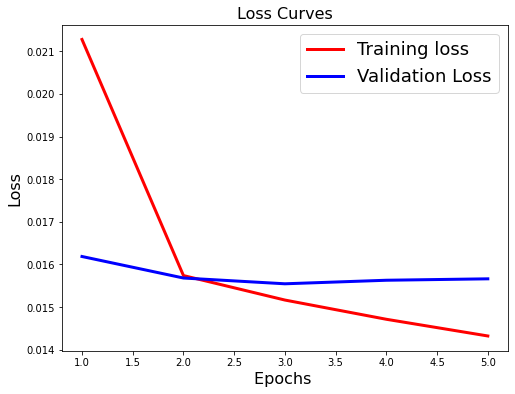

In [14]:
# Loss Curves
plt.figure(figsize=[8,6])
plt.plot([1, 2, 3, 4, 5], history.history['loss'],'r',linewidth=3.0)
plt.plot([1, 2, 3, 4, 5], history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

In [ ]:
x = [1, 2]

In [ ]:
history.history['loss'] 

[0.020219668745994568, 0.01570735312998295]

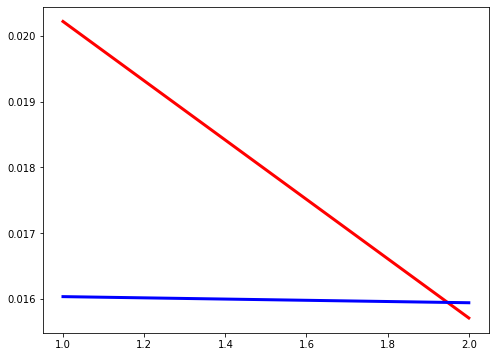

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=[8,6])
plt.plot(x, history.history['loss'],'r',linewidth=3.0)
plt.plot(x, history.history['val_loss'],'b',linewidth=3.0)

In [ ]:
submit = model.predict(lstm_test)
submit = np.squeeze(submit)

test_df = pd.read_csv('gdrive/My Drive/Python/test.csv', index_col='id', engine='python')
test_df = test_df.drop(columns = ['comment_text'])
test_df['prediction'] = submit.tolist()

test_df.head(5)

,prediction
id,
7097320,0.028286
7097321,0.034794
7097322,0.120455
7097323,0.012419
7097324,0.012306


In [ ]:
!pip install --no-index --find-links="../input/pytorchpretrainedbert/" pytorch_pretrained_bert

Looking in links: ../input/pytorchpretrainedbert/
ERROR: Could not find a version that satisfies the requirement pytorch_pretrained_bert (from versions: none)
ERROR: No matching distribution found for pytorch_pretrained_bert


In [ ]:
import numpy as np 
import pandas as pd 
import os
from tqdm import tqdm, trange
from sklearn.metrics import roc_auc_score
import pickle
import gc

In [ ]:
os.listdir()


['.config', 'gdrive', 'sample_data']

In [ ]:
import numpy as np
import pandas as pd
from keras.models import Model
from keras.layers import Input, Dense, Embedding, SpatialDropout1D, add, concatenate
from keras.layers import CuDNNLSTM, Bidirectional, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import text, sequence
from gensim.models import KeyedVectors


EMBEDDING_FILES = [
    '/content/gdrive/MyDrive/Python/crawl-300d-2M.gensim',
    '/content/gdrive/MyDrive/Python/glove.840B.300d.gensim'
]
NUM_MODELS = 2
BATCH_SIZE = 512
LSTM_UNITS = 128
DENSE_HIDDEN_UNITS = 4 * LSTM_UNITS
EPOCHS = 4
MAX_LEN = 220
IDENTITY_COLUMNS = [
    'male', 'female', 'homosexual_gay_or_lesbian', 'christian', 'jewish',
    'muslim', 'black', 'white', 'psychiatric_or_mental_illness'
]
AUX_COLUMNS = ['target', 'severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat']
TEXT_COLUMN = 'comment_text'
TARGET_COLUMN = 'target'
CHARS_TO_REMOVE = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n“”’\'∞θ÷α•à−β∅³π‘₹´°£€\×™√²—'


def build_matrix(word_index, path):
    embedding_index = KeyedVectors.load(path, mmap='r')
    embedding_matrix = np.zeros((len(word_index) + 1, 300))
    for word, i in word_index.items():
        for candidate in [word, word.lower()]:
            if candidate in embedding_index:
                embedding_matrix[i] = embedding_index[candidate]
                break
    return embedding_matrix
    

def build_model(embedding_matrix, num_aux_targets):
    words = Input(shape=(None,))
    x = Embedding(*embedding_matrix.shape, weights=[embedding_matrix], trainable=False)(words)
    x = SpatialDropout1D(0.2)(x)
    x = Bidirectional(CuDNNLSTM(LSTM_UNITS, return_sequences=True))(x)
    x = Bidirectional(CuDNNLSTM(LSTM_UNITS, return_sequences=True))(x)

    hidden = concatenate([
        GlobalMaxPooling1D()(x),
        GlobalAveragePooling1D()(x),
    ])
    hidden = add([hidden, Dense(DENSE_HIDDEN_UNITS, activation='relu')(hidden)])
    hidden = add([hidden, Dense(DENSE_HIDDEN_UNITS, activation='relu')(hidden)])
    result = Dense(1, activation='sigmoid')(hidden)
    aux_result = Dense(num_aux_targets, activation='sigmoid')(hidden)
    
    model = Model(inputs=words, outputs=[result, aux_result])
    model.compile(loss='binary_crossentropy', optimizer='adam')

    return model
    



In [ ]:
train_df = pd.read_csv('/content/gdrive/MyDrive/Python/train.csv')
test_df = pd.read_csv('/content/gdrive/MyDrive/Python/test.csv')

x_train = train_df[TEXT_COLUMN].astype(str)
y_train = train_df[TARGET_COLUMN].values
y_aux_train = train_df[AUX_COLUMNS].values
x_test = test_df[TEXT_COLUMN].astype(str)

for column in IDENTITY_COLUMNS + [TARGET_COLUMN]:
    train_df[column] = np.where(train_df[column] >= 0.5, True, False)

tokenizer = text.Tokenizer(filters=CHARS_TO_REMOVE, lower=False)
tokenizer.fit_on_texts(list(x_train) + list(x_test))

x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)
x_train = sequence.pad_sequences(x_train, maxlen=MAX_LEN)
x_test = sequence.pad_sequences(x_test, maxlen=MAX_LEN)

sample_weights = np.ones(len(x_train), dtype=np.float32)
sample_weights += train_df[IDENTITY_COLUMNS].sum(axis=1)
sample_weights += train_df[TARGET_COLUMN] * (~train_df[IDENTITY_COLUMNS]).sum(axis=1)
sample_weights += (~train_df[TARGET_COLUMN]) * train_df[IDENTITY_COLUMNS].sum(axis=1) * 5
sample_weights /= sample_weights.mean()





In [ ]:
%time
embedding_matrix = np.concatenate(
    [build_matrix(tokenizer.word_index, f) for f in EMBEDDING_FILES], axis=-1)

checkpoint_predictions = []
weights = []

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs


In [ ]:
train_df.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,False,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,False,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,False,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
3,59855,False,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
4,59856,True,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,...,2006,rejected,0,0,0,1,0,0.0,4,47


In [ ]:
for model_idx in range(NUM_MODELS):
    model = build_model(embedding_matrix, y_aux_train.shape[-1])
    for global_epoch in range(EPOCHS):
        model.fit(
            x_train,
            [y_train, y_aux_train],
            batch_size=BATCH_SIZE,
            epochs=1,
            verbose=2,
            sample_weight=[sample_weights.values, np.ones_like(sample_weights)]
        )
        checkpoint_predictions.append(model.predict(x_test, batch_size=2048)[0].flatten())
        weights.append(2 ** global_epoch)



In [ ]:
predictions = np.average(checkpoint_predictions, weights=weights, axis=0)

submission = pd.DataFrame.from_dict({
    'id': test_df.id,
    'prediction': predictions
})
submission.to_csv('submission.csv', index=False)